In [1]:
#    * movie_genres.dat
#    This file contains the genres of the movies.

#    * movie_directors.dat
#    This file contains the directors of the movies.
   
#    * movie_actors.dat
#    This file contains the main actores and actresses of the movies.
#    A ranking is given to the actors of each movie according to the order in which 
#    they appear on the movie IMDb cast web page.

#    * tags.dat
#    This file contains the set of tags available in the dataset.
   
#    * user_taggedmovies.dat    
#    These files contain the tag assignments of the movies provided by each particular user.

#    * movie_tags.dat
#    This file contains the tags assigned to the movies, and the number of times 
#    the tags were assigned to each movie.

# The data is tab-separated and space separated- need to look at files to see what sep to use

In [2]:
# !pip3 install seaborn
# !pip3 install imbalanced-learn

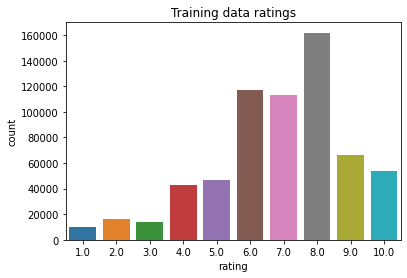

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

training_data = pd.read_table('additional_files/train.dat', sep=' ')
test_data = pd.read_table('additional_files/test.dat', sep=' ')

training_data["rating"] = training_data["rating"]*2
movie_genres = pd.read_table('additional_files/movie_genres.dat')
movie_directors = pd.read_table('additional_files/movie_directors.dat', encoding='latin1')
movie_actors = pd.read_table('additional_files/movie_actors.dat', encoding='latin1')
tags = pd.read_table('additional_files/tags.dat', encoding='latin1')
movie_tags = pd.read_table('additional_files/movie_tags.dat')
user_taggedmovies = pd.read_table('additional_files/user_taggedmovies.dat', sep=' ')

fig , ax = plt.subplots(figsize=(6,4))
sns.countplot(x='rating', data=training_data)
plt.title("Training data ratings")
plt.show()

In [4]:
# # setting up 10 unique bins
rating_bins = training_data['rating']*2

# remove ratings and add after a new intialization later
user_movie= training_data.drop(columns='rating')

In [5]:
# get set of all unique genres in the data
list_unique_genres = list(set(movie_genres['genre']))
# list_unique_genres

In [6]:
list_movie_genre=[]
count = 0
# len(user_movie)
for i1,r1 in user_movie.iterrows():
#     print(r1.movieID)
    
#     get a set of all unique movie ID's and append their genres together
    match_var = movie_genres.loc[movie_genres['movieID']==r1.movieID]

    combined_genre = ""
    for i2,r2 in match_var.iterrows():
#         using a '|' as seperator
        combined_genre += r2.genre + "|"
    list_movie_genre.append(combined_genre)
    count+=1

In [7]:
user_movie['rating'] = rating_bins
user_movie['genres'] = list_movie_genre

In [8]:
count = 0
for val in list_unique_genres:
    user_movie[val] = user_movie.apply(lambda x:int(val in x.genres), axis = 1)
    count+=1

In [9]:
training_data = user_movie
training_data['rating']=training_data['rating']/2

In [10]:
movie_genres = pd.read_table('additional_files/movie_genres.dat')
list_unique_genres_test = list(set(movie_genres['genre']))
list_movie_genre_test=[]
count = 0
user_movie_test = test_data

# len(user_movie)
for i1,r1 in user_movie_test.iterrows():
#     print(r1.movieID)
    
#     get a set of all unique movie ID's and append their genres together
    match_var = movie_genres.loc[movie_genres['movieID']==r1.movieID]

    combined_genre = ""
    for i2,r2 in match_var.iterrows():
#         using a '|' as seperator
        combined_genre += r2.genre + "|"
    list_movie_genre_test.append(combined_genre) 
    count+=1


In [11]:
user_movie_test['genres'] = list_movie_genre_test
count = 0
for val in list_unique_genres_test:
    user_movie_test[val] = user_movie_test.apply(lambda x:int(val in x.genres), axis = 1)
    count+=1

In [12]:
test_data = user_movie_test

In [13]:
# some of the categoricals were already encoded
numerical_features = ['movieID','userID','Action','Musical','IMAX','Romance','Comedy','Adventure','Crime','Short','Film-Noir','Western', 'Animation','Drama','War','Mystery','Documentary', 'Horror', 'Children', 'Thriller', 'Sci-Fi', 'Fantasy']

# categorical_features = ['userID']

model_features = numerical_features #+ categorical_features
model_target = "rating"

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
# from imblearn.pipeline import Pipeline #sampling not compatible with sklearn pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split


# Preprocess numerical features
numerical_processor = Pipeline([('num_scaler', MinMaxScaler())])

# Encode categorical features - race and gender
# categorical_processor = Pipeline([('cat_encoder', OneHotEncoder(handle_unknown='ignore'))])

data_preprocessor = ColumnTransformer([
    ('numerical', numerical_processor, numerical_features),
#     ('categorical', categorical_processor, categorical_features)
                                    ])

pipeline = Pipeline([
#     ('oversampler', RandomOverSampler(random_state = 25, sampling_strategy = 0.60)),
    ('data_preprocessing', data_preprocessor),
    ('rf', MultinomialNB())
                    ])

train_data, val_data = train_test_split(training_data, test_size=0.2, shuffle=True, random_state=23)

# train pipeline
X_train = train_data[model_features]
y_train = train_data['rating'].tolist()
pipeline.fit(X_train, y_train)
train_predictions = pipeline.predict(X_train)

# test pipeline
X_test = val_data[model_features]
y_test = val_data["rating"].tolist()

# predict the test dataset
test_predictions = pipeline.predict(X_test)

In [14]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

param_grid = {'rf__alpha': np.arange(0.1, 4.5)}

grid_search = RandomizedSearchCV(pipeline, 
                           param_grid, 
                           cv = 5, # 5 fold cv
                           verbose = 1,
                           n_jobs = -1,
                           scoring = "neg_root_mean_squared_error"
                          )

grid_search.fit(X_train, y_train)
grid_search.cv_results_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   13.4s finished


{'mean_fit_time': array([1.51110201, 1.54688921, 1.56188202, 1.56800108, 1.39129515]),
 'std_fit_time': array([0.04667579, 0.03297527, 0.04154887, 0.04933381, 0.25263184]),
 'mean_score_time': array([0.0910398 , 0.09734106, 0.08798766, 0.08665452, 0.07731009]),
 'std_score_time': array([0.00717159, 0.00885611, 0.00503515, 0.00583175, 0.01838053]),
 'param_rf__alpha': masked_array(data=[0.1, 1.1, 2.1, 3.1, 4.1],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'rf__alpha': 0.1},
  {'rf__alpha': 1.1},
  {'rf__alpha': 2.1},
  {'rf__alpha': 3.1},
  {'rf__alpha': 4.1}],
 'split0_test_score': array([-2.24541548, -2.24538945, -2.24539813, -2.24548488, -2.24546753]),
 'split1_test_score': array([-2.24468664, -2.24475607, -2.24479078, -2.24482549, -2.24483416]),
 'split2_test_score': array([-2.23911058, -2.23914538, -2.23917147, -2.23915407, -2.23917147]),
 'split3_test_score': array([-2.24367542, -2.24367542, -2.24366674, 

In [15]:
classifier = grid_search.best_estimator_
print(classifier)
classifier = pipeline
# Fit the best model
classifier.fit(X_train, y_train)

# predictions on training data
train_predictions = classifier.predict(X_train)

# Get test data to test the classifier
X_test = val_data[model_features]
y_test = val_data["rating"].tolist()

# Test data going through the Pipeline-- it's sampled, encoded, scaled, then used to make predictions
test_predictions = classifier.predict(X_test)

Pipeline(steps=[('data_preprocessing',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('num_scaler',
                                                                   MinMaxScaler())]),
                                                  ['movieID', 'userID',
                                                   'Action', 'Musical', 'IMAX',
                                                   'Romance', 'Comedy',
                                                   'Adventure', 'Crime',
                                                   'Short', 'Film-Noir',
                                                   'Western', 'Animation',
                                                   'Drama', 'War', 'Mystery',
                                                   'Documentary', 'Horror',
                                                   'Children', 'Thriller',
                                                   'Sci-F

In [16]:
x_train = pd.DataFrame(training_data, columns=numerical_features)#+categorical_features)
y_train = training_data['rating'].tolist()

# Fit the model to our training data
classifier.fit(x_train, y_train)

x_test = pd.DataFrame(test_data, columns=numerical_features)#+categorical_features)

test_predictions = classifier.predict(x_test)

with open('hw4_result.txt', 'w') as filehandle:
    filehandle.writelines("{}\n".format(t/2) for t in test_predictions)